In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

# BEST >.95

In [2]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from vit_pytorch.vit import ViT
from kan import *


import time
import gc
import copy
import traceback
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import torch.optim as optim
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [3]:
SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [4]:
folder="data/hill-valley"
x_col=["V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20",
"V21","V22","V23","V24","V25","V26","V27","V28","V29","V30","V31","V32","V33","V34","V35","V36","V37","V38","V39","V40",
"V41","V42","V43","V44","V45","V46","V47","V48","V49","V50","V51","V52","V53","V54","V55","V56","V57","V58","V59","V60",
"V61","V62","V63","V64","V65","V66","V67","V68","V69","V70","V71","V72","V73","V74","V75","V76","V77","V78","V79","V80",
"V81","V82","V83","V84","V85","V86","V87","V88","V89","V90","V91","V92","V93","V94","V95","V96","V97","V98","V99","V100"]
target_col=["class"]

In [5]:
def load_and_clean(npy_filename, y_filename, x_col, target_col):
    """
    Load the feature array (npy_filename) and label array (y_filename),
    drop rows in the feature array that contain any NaNs, and apply
    the same mask to the label array.
    """
    # Load numpy arrays
    X = np.load(os.path.join(folder, npy_filename))
    y = np.load(os.path.join(folder, y_filename), allow_pickle=True)
    
    # Ensure the number of rows matches between X and y
    if X.shape[0] != y.shape[0]:
        raise ValueError("The number of rows in {} and {} do not match.".format(npy_filename, y_filename))
    
    # Create a boolean mask for rows that do NOT have any NaN values in X
    valid_rows = ~np.isnan(X).any(axis=1)
    #print(valid_rows)
    # Filter both arrays using the valid_rows mask
    X_clean = X[valid_rows]
    y_clean = y[valid_rows]
    
    # Convert arrays to DataFrames
    df_X = pd.DataFrame(X_clean)
    df_y = pd.DataFrame(y_clean)
    df_X.columns = x_col
    df_y.columns = target_col
    return df_X, df_y

X_train, y_train = load_and_clean('N_train.npy', 'y_train.npy',x_col, target_col)
X_test, y_test   = load_and_clean('N_test.npy',  'y_test.npy', x_col, target_col)
X_val, y_val     = load_and_clean('N_val.npy',   'y_val.npy', x_col, target_col)

In [6]:
y_train['class'] = y_train['class'].apply(int)
y_test['class'] = y_test['class'].apply(int)
y_val['class'] = y_val['class'].apply(int)

In [7]:
# Function to load and preprocess data
def load_and_preprocess_data(X_train, y_train, X_test, y_test, X_val, y_val, image_model, problem_type, batch_size=32):
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/train'):
        #Generate thet images
        image_model.fit_transform(X_train, f'{images_folder}/train')
        image_model.saveHyperparameters(f'{images_folder}'+"/model.pkl")
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/train',problem_type+".csv")

    print(img_paths)
    
    imgs_train = pd.read_csv(img_paths)
    
    # Update image paths
    imgs_train["images"] = images_folder + "/train/" + imgs_train["images"]

    # Combine datasets
    #combined_dataset = pd.concat([imgs, X_train], axis=1)
    
    # Split data
    #X_train = combined_dataset.drop(target_col, axis=1).drop("values", axis=1)
    #y_train = combined_dataset["values"]
        
    ### X_val
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/val'):
        #Generate thet images
        image_model.transform(X_val, f'{images_folder}/val')
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/val',problem_type+".csv")

    print(img_paths)
    
    imgs_val = pd.read_csv(img_paths)

    # Update image paths
    imgs_val["images"] = images_folder + "/val/" + imgs_val["images"]

    # Combine datasets
    #combined_dataset = pd.concat([imgs, X_val], axis=1)

    # Split data
    #X_val = combined_dataset.drop(target_col, axis=1).drop("values", axis=1)
    #y_val = combined_dataset["values"]
    
    ### X_test
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/test'):
        #Generate thet images
        image_model.transform(X_test, f'{images_folder}/test')
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/test',problem_type+".csv")

    print(img_paths)
    
    imgs_test = pd.read_csv(img_paths)

    # Update image paths
    imgs_test["images"] = images_folder + "/test/" + imgs_test["images"]

    # Combine datasets
    #combined_dataset = pd.concat([imgs, X_test], axis=1)

    # Split data
    #X_test = combined_dataset.drop(target_col, axis=1).drop("values", axis=1)
    #y_test = combined_dataset["values"]
    
    # Numerical data
    X_train_num = X_train#.drop("images", axis=1)
    X_val_num = X_val#.drop("images", axis=1)
    X_test_num = X_test#.drop("images", axis=1)

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in imgs_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in imgs_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in imgs_test["images"]])

    ## Create a MinMaxScaler object
    scaler = MinMaxScaler()

    ## Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val_num), columns=X_val_num.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)
    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    y_val_tensor = torch.as_tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Normalize to [0, 1]
    X_train_img_tensor = X_train_img_tensor / 255.0
    X_val_img_tensor = X_val_img_tensor / 255.0
    X_test_img_tensor = X_test_img_tensor / 255.0

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_num_tensor, X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_num_tensor, X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_num_tensor, X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape 


In [8]:
# Get the shape of the dataframe
num_columns = X_train.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

10


In [10]:
from TINTOlib.igtd import IGTD
dataset_name = 'hill-valley'
#Select the model and the parameters
problem_type = "supervised"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', error='abs', max_step=30000, val_step=300, random_seed=SEED)
name = f"IGTD_{image_size}x{image_size}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"HyNNImages/Classification/{dataset_name}/images_{dataset_name}_{name}"

In [11]:
train_loader, val_loader, test_loader, attributes, imgs_shape = load_and_preprocess_data(
    X_train, y_train, X_test, y_test, X_val, y_val,
    image_model=image_model,
    problem_type=problem_type,
    batch_size=16
)

The images are already generated
HyNNImages/Classification/hill-valley/images_hill-valley_IGTD_10x10_fEuclidean_iEuclidean_abs/train\supervised.csv
The images are already generated
HyNNImages/Classification/hill-valley/images_hill-valley_IGTD_10x10_fEuclidean_iEuclidean_abs/val\supervised.csv
The images are already generated
HyNNImages/Classification/hill-valley/images_hill-valley_IGTD_10x10_fEuclidean_iEuclidean_abs/test\supervised.csv
Images shape:  (3, 10, 10)
Attributes:  100


In [12]:
def combine_loader(loader):
    """
    Combines all batches from a DataLoader into three tensors.
    Assumes each batch is a tuple: (mlp_tensor, img_tensor, target_tensor)
    """
    mlp_list, img_list, target_list = [], [], []
    for mlp, img, target in loader:
        mlp_list.append(mlp)
        img_list.append(img)
        target_list.append(target)
    return torch.cat(mlp_list, dim=0), torch.cat(img_list, dim=0), torch.cat(target_list, dim=0)

In [13]:
# Combine dataloaders into tensors.
train_mlp, train_img, train_target = combine_loader(train_loader)
val_mlp, val_img, val_target = combine_loader(val_loader)
test_mlp, test_img, test_target = combine_loader(test_loader)

dataset = {
    "train_input": train_mlp.to(device),
    "train_img": train_img.to(device),
    "train_label": train_target.to(device),
    "val_input": val_mlp.to(device),
    "val_img": val_img.to(device),
    "val_label": val_target.to(device),
    "test_input": test_mlp.to(device),
    "test_img": test_img.to(device),
    "test_label": test_target.to(device),
}

In [14]:
# Print the shapes of the tensors
print("Train data shape:", dataset['train_input'].shape)
print("Train target shape:", dataset['train_label'].shape)
print("Test data shape:", dataset['test_input'].shape)
print("Test target shape:", dataset['test_label'].shape)
print("Validation data shape:", dataset['val_input'].shape)
print("Validation target shape:", dataset['val_label'].shape)

Train data shape: torch.Size([775, 100])
Train target shape: torch.Size([775, 1])
Test data shape: torch.Size([243, 100])
Test target shape: torch.Size([243, 1])
Validation data shape: torch.Size([194, 100])
Validation target shape: torch.Size([194, 1])


In [15]:
dtype = torch.get_default_dtype()

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).type(dtype))

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).type(dtype))

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.72e-01 | test_loss: 4.95e-01 | reg: 6.54e+01 | : 100%|█| 50/50 [00:14<00:00,  3.43it

saving model version 0.1
0.843870997428894 0.8189300298690796
tensor(0.8196, device='cuda:0')


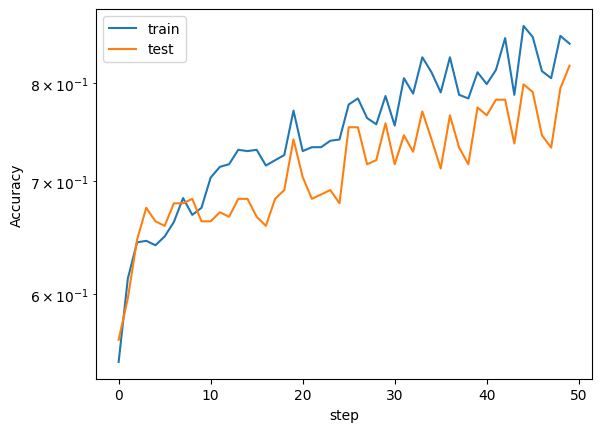

In [40]:
model = KAN(width=[attributes, 2, 1], grid=3, k=3, seed=381, device=device)
results = model.fit(dataset, opt="LBFGS", steps=50, metrics=(train_acc, test_acc), lamb=.0001)
print(results['train_acc'][-1], results['test_acc'][-1])
print(torch.mean((torch.round(model(dataset['val_input'])[:,0]) == dataset['val_label'][:,0]).type(dtype)))
plt.plot(results['train_acc'])
plt.plot(results['test_acc'])
plt.legend(['train', 'test'])
plt.ylabel('Accuracy')
plt.xlabel('step')
plt.yscale('log')

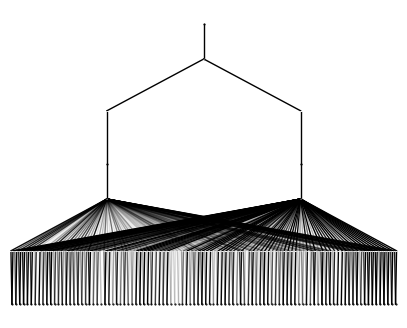

In [41]:
model.plot()

# Hibrids

In [16]:
class Model3(nn.Module):
    def __init__(self, attributes, imgs_shape, device):
        super(Model3, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=2),
            nn.BatchNorm2d(16),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)
        # Final KAN layers
        self.m_kan = KAN(
            width=[attributes, 2],
            grid=3,
            k=3,
            seed=SEED,
            device=device
        )
        # Calculate the size of the flattened CNN output
        self.cnn_output_size = 16 * (imgs_shape[1] - 1) * (imgs_shape[2] - 1)
        # Final MLP layers
        self.final_kan = KAN(
            width=[self.cnn_output_size + 2, 1],
            grid=3,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [18]:
import os
import time
import copy
import numpy as np
import torch
import torch.optim as optim
from torch.optim import LBFGS
from tqdm import tqdm
import matplotlib.pyplot as plt

def fit_hybrid_dataloaders(model, 
                           dataset,
                           opt="Adam", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for validation
        - test_loader: provides (mlp, img, target) for evaluation during training

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    #device = next(model.parameters()).device

    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.m_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.m_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.m_kan, "disable_symbolic_in_fit"):
        old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
        f_old_save_act, f_old_symbolic_enabled = model.final_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_input"].shape[0]
    n_eval  = dataset["test_input"].shape[0]  # using test set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {
        'train_loss': [],
        'eval_loss': [],
        'val_loss': [],
        'reg': []
    }

    
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)

        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val_inner = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                
                #reg_val_inner = reg_val_inner + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            
            mlp_batch = dataset['train_input'][train_indices]
            cnn_batch = dataset['train_img'][train_indices]
            
            model.m_kan.update_grid(mlp_batch)
            #cnn_output = model.cnn_branch(cnn_batch)  # Process image input
            concatenated  = model.get_concat_output(mlp_batch, cnn_batch)
            #concatenated = torch.cat((mlp_batch, cnn_output), dim=1)
            model.final_kan.update_grid(concatenated)

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = closure()  # re-evaluate to record loss
            # Compute reg_val separately for logging
            with torch.no_grad():
                mlp_batch = dataset["train_input"][train_indices]
                img_batch = dataset["train_img"][train_indices]
                target_batch = dataset["train_label"][train_indices]
                outputs = model(mlp_batch, img_batch)
                train_loss = loss_fn(outputs, target_batch)
                if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                    if reg_metric == 'edge_backward':
                        model.m_kan.attribute()
                        model.final_kan.attribute()
                    if reg_metric == 'node_backward':
                        model.m_kan.node_attribute()
                        model.final_kan.node_attribute()
                    reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                    #reg_val = reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                else:
                    reg_val = torch.tensor(0., device=device)
        else:  # Adam branch
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                #reg_val = reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()

        # Evaluate on the entire evaluation set (from test_loader)
        mlp_eval = dataset["test_input"][eval_indices]
        img_eval = dataset["test_img"][eval_indices]
        target_eval = dataset["test_label"][eval_indices]
        eval_loss = loss_fn(model(mlp_eval, img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['train_loss'].append(torch.sqrt(loss_val.detach()).item())
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        # New: Compute validation loss if validation data exists in the dataset.
        # val_loss = loss_fn(model(dataset['val_input'][eval_indices], dataset['val_img'][eval_indices]), dataset['val_label'][eval_indices])
        # results['val_loss'].append(torch.sqrt(val_loss).cpu().detach().numpy())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())

        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            desc = ""
            data = []
            for metric in display_metrics:
                desc += f" {metric}: %.2e |"
                data.append(results[metric.__name__][-1])
            pbar.set_description(desc % tuple(data))

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.m_kan, "save_act", False)
            model.m_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.m_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.m_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.m_kan, "log_history"):
        model.m_kan.log_history('fit')

    return results

In [19]:
import traceback

def try_create_model(model_class, attributes, imgs_shape, device):
    try:
        model = model_class(attributes, imgs_shape, device)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}:")
        traceback.print_exc()
        return None

In [20]:
dtype = torch.get_default_dtype()

def train_acc():
    return torch.mean((torch.round(model3(dataset['train_input'], dataset['train_img'])[:,0]) == dataset['train_label'][:,0]).type(dtype))

def test_acc():
    return torch.mean((torch.round(model3(dataset['test_input'], dataset['test_img'])[:,0]) == dataset['test_label'][:,0]).type(dtype))

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 4.49e-01 | eval_loss: 4.66e-01 | reg: 3.03e-01 |: 100%|█| 10/10 [00:08<00:00,  1.21it/

saving model version 0.1
0.6838709712028503 0.6584361791610718
tensor(0.6495, device='cuda:0')


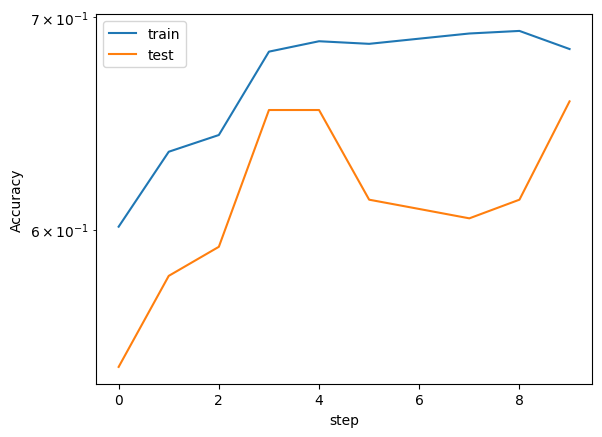

In [27]:
model3 = try_create_model(Model3, attributes, imgs_shape, device)  # Attempt to create Model3
metrics3 = fit_hybrid_dataloaders(model3, dataset, opt="LBFGS", metrics=(train_acc, test_acc), steps=10, lamb=.01)

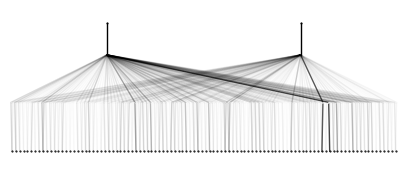

In [28]:
model3.m_kan.plot()

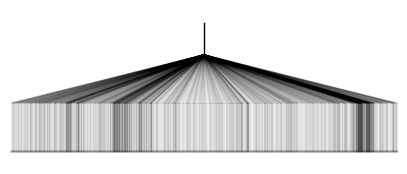

In [29]:
model3.final_kan.plot()

In [30]:
model3.final_kan.feature_score

tensor([9.5686e-06, 1.9539e-05, 3.2145e-03,  ..., 1.0485e-02, 1.4223e-02,
        1.0075e-03], device='cuda:0', grad_fn=<MeanBackward1>)

In [34]:
class Model4(nn.Module):
    def __init__(self, attributes, imgs_shape, device):
        super(Model4, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], out_channels=16, kernel_size=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 8, kernel_size=2, padding=1),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)
        # Middfle KAN layers
        self.m_kan = KAN(
            width=[attributes, 2],
            grid=3,
            k=3,
            seed=SEED,
            device=device
        )
        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)
        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + 2, 1],
            grid=3,
            k=3,
            device=device
        )
        
        self.device = device
    
    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)


    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [35]:
dtype = torch.get_default_dtype()

def train_acc():
    return torch.mean((torch.round(model4(dataset['train_input'], dataset['train_img'])[:,0]) == dataset['train_label'][:,0]).type(dtype))

def test_acc():
    return torch.mean((torch.round(model4(dataset['test_input'], dataset['test_img'])[:,0]) == dataset['test_label'][:,0]).type(dtype))

In [49]:
import os
import time
import copy
import numpy as np
import torch
import torch.optim as optim
from torch.optim import LBFGS
from tqdm import tqdm
import matplotlib.pyplot as plt

def fit_hybrid_dataloaders(model, 
                           dataset,
                           opt="Adam", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for validation
        - test_loader: provides (mlp, img, target) for evaluation during training

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    #device = next(model.parameters()).device

    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.m_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.m_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.m_kan, "disable_symbolic_in_fit"):
        old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
        f_old_save_act, f_old_symbolic_enabled = model.final_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_input"].shape[0]
    n_eval  = dataset["test_input"].shape[0]  # using test set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {
        'train_loss': [],
        'eval_loss': [],
        'val_loss': [],
        'reg': []
    }

    
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)

        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val_inner = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                
                reg_val_inner = reg_val_inner + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            
            mlp_batch = dataset['train_input'][train_indices]
            cnn_batch = dataset['train_img'][train_indices]
            
            model.m_kan.update_grid(mlp_batch)
            #cnn_output = model.cnn_branch(cnn_batch)  # Process image input
            concatenated  = model.get_concat_output(mlp_batch, cnn_batch)
            #concatenated = torch.cat((mlp_batch, cnn_output), dim=1)
            model.final_kan.update_grid(concatenated)

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = closure()  # re-evaluate to record loss
            # Compute reg_val separately for logging
            with torch.no_grad():
                mlp_batch = dataset["train_input"][train_indices]
                img_batch = dataset["train_img"][train_indices]
                target_batch = dataset["train_label"][train_indices]
                outputs = model(mlp_batch, img_batch)
                train_loss = loss_fn(outputs, target_batch)
                if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                    if reg_metric == 'edge_backward':
                        model.m_kan.attribute()
                        model.final_kan.attribute()
                    if reg_metric == 'node_backward':
                        model.m_kan.node_attribute()
                        model.final_kan.node_attribute()
                    reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                    reg_val = reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                else:
                    reg_val = torch.tensor(0., device=device)
        else:  # Adam branch
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                reg_val = reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()

        # Evaluate on the entire evaluation set (from test_loader)
        mlp_eval = dataset["test_input"][eval_indices]
        img_eval = dataset["test_img"][eval_indices]
        target_eval = dataset["test_label"][eval_indices]
        eval_loss = loss_fn(model(mlp_eval, img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['train_loss'].append(torch.sqrt(loss_val.detach()).item())
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        # New: Compute validation loss if validation data exists in the dataset.
        # val_loss = loss_fn(model(dataset['val_input'][eval_indices], dataset['val_img'][eval_indices]), dataset['val_label'][eval_indices])
        # results['val_loss'].append(torch.sqrt(val_loss).cpu().detach().numpy())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())

        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            desc = ""
            data = []
            for metric in display_metrics:
                desc += f" {metric}: %.2e |"
                data.append(results[metric.__name__][-1])
            pbar.set_description(desc % tuple(data))

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.m_kan, "save_act", False)
            model.m_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.m_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.m_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.m_kan, "log_history"):
        model.m_kan.log_history('fit')

    return results

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.32e-01 | eval_loss: 4.63e-01 | reg: 1.15e+01 |: 100%|█| 10/10 [00:03<00:00,  2.98it/

saving model version 0.1
0.7006452083587646 0.6419752836227417
tensor(0.6392, device='cuda:0')


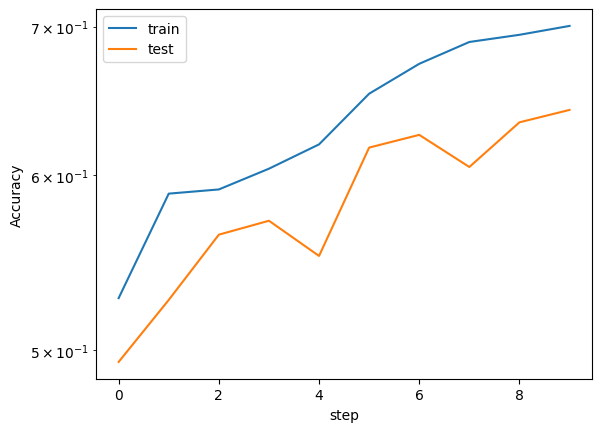

In [50]:
model4 = try_create_model(Model4, attributes, imgs_shape, device)  # Attempt to create Model3
metrics4 = fit_hybrid_dataloaders(model4, dataset, opt="LBFGS", metrics=(train_acc, test_acc), steps=10, lamb=.001)

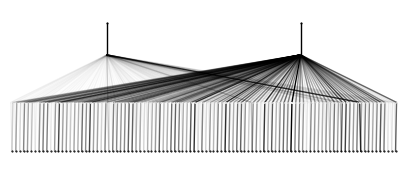

In [51]:
model4.m_kan.plot()

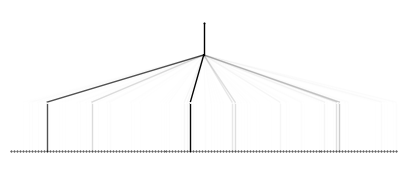

In [52]:
model4.final_kan.plot()

In [53]:
model4.final_kan.feature_score

tensor([4.0289e-04, 2.5104e-04, 2.8512e-04, 4.9229e-04, 1.1752e-03, 1.9466e-04,
        2.4788e-03, 2.0228e-03, 3.5430e-04, 3.0548e-03, 2.3160e-04, 1.7838e-04,
        2.7430e-01, 7.2453e-04, 2.9602e-04, 4.1952e-04, 7.5971e-04, 8.4471e-04,
        6.7179e-04, 1.9001e-04, 5.7929e-04, 5.0810e-04, 1.8446e-03, 2.3048e-03,
        6.4503e-04, 1.4980e-03, 8.4687e-04, 4.7280e-02, 6.2522e-04, 2.1828e-03,
        3.2847e-04, 1.4948e-04, 2.4213e-03, 3.3360e-03, 1.4679e-04, 8.2587e-05,
        9.7783e-05, 5.3558e-04, 2.5595e-04, 5.1640e-04, 2.1577e-03, 7.3637e-04,
        3.9797e-04, 1.3952e-03, 1.9941e-04, 6.4291e-04, 2.9584e-04, 4.8944e-04,
        2.7693e-04, 1.8249e-04, 1.0896e-03, 7.6498e-04, 1.7913e-03, 3.1493e-03,
        4.6245e-04, 4.8319e-04, 4.2809e-04, 9.2270e-04, 1.0543e-02, 9.0828e-03,
        7.4296e-01, 5.7007e-03, 1.5963e-03, 2.4376e-04, 5.2089e-04, 3.7712e-03,
        3.8120e-05, 2.0947e-03, 1.2379e-03, 6.6629e-04, 1.7650e-03, 1.3807e-03,
        4.8151e-04, 5.1731e-04, 3.0041e-

In [57]:
model4 = try_create_model(Model4, attributes, imgs_shape, device)  # Attempt to create Model3
metrics4 = fit_hybrid_dataloaders(model4, dataset, opt="LBFGS", metrics=(train_acc, test_acc), steps=40, lamb=.0001)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.95e-01 | eval_loss: 5.90e-01 | reg: 2.70e+01 |: 100%|█| 40/40 [00:13<00:00,  2.98it/

saving model version 0.1


0.7303225994110107 0.588477373123169
tensor(0.6340, device='cuda:0')


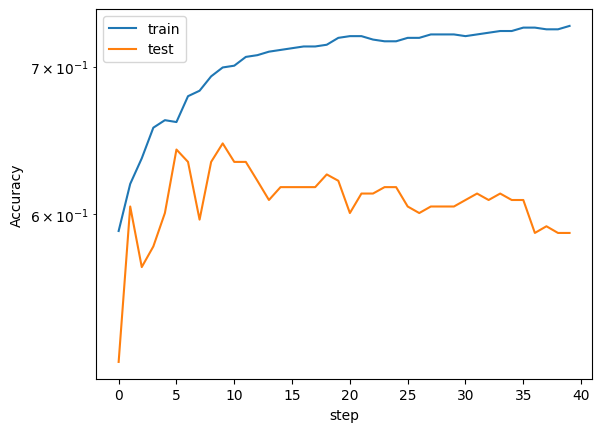

In [58]:
print(metrics4['train_acc'][-1], metrics4['test_acc'][-1])
print(torch.mean((torch.round(model4(dataset['val_input'], dataset['val_img'])[:,0]) == dataset['val_label'][:,0]).type(dtype)))
plt.plot(metrics4['train_acc'])
plt.plot(metrics4['test_acc'])
plt.legend(['train', 'test'])
plt.ylabel('Accuracy')
plt.xlabel('step')
plt.yscale('log')